# MTM Air Quality

## Load Libs


In [ ]:
import os
from datetime import datetime as dt

import icecream
import pandas as pd
import pytorch_lightning as L
import torch
from icecream import ic
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

import hephaestus as hp
from hephaestus.timeseries_models import tabular_collate_fn

# %%
torch.set_default_dtype(torch.float32)
# %%
icecream.install()
ic_disable = True  # Global variable to disable ic
if ic_disable:
    ic.disable()
ic.configureOutput(includeContext=True, contextAbsPath=True)
# pd.options.mode.copy_on_write = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Load and Process Data


In [3]:
# Load and preprocess the dataset (assuming you have a CSV file)
# Select numeric columns

csvs = [
    os.path.join("./data/air_quality/", f)
    for f in os.listdir("./data/air_quality/")
    if f.endswith(".csv")
]
dfs = [pd.read_csv(csv) for csv in csvs]
df = pd.concat(dfs, ignore_index=True)
del dfs
time_cols = ["year", "month", "day", "hour"]
df = df.sort_values(time_cols).reset_index(drop=True).drop("No", axis=1)
# Convert time columns to strings
for col in time_cols:
    df[col] = df[col].astype(str)
# replace . and lower case column names
df.columns = [c.replace(".", "_").lower() for c in df.columns]
# df = df.dropna()
df_no_na = df.dropna()
print(df.shape)
df.dropna(subset=["pm2_5"], inplace=True)
print(df.shape)
df = df.reset_index(drop=True)

df["idx"] = df.index // 32
# df = df.drop(["year", "month", "day", "hour"], axis=1)
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
numeric_cols.remove("idx")  # Remove idx column from scaling

# Create and fit scaler
scale_data = True
if scale_data:
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df.head()

(420768, 17)
(412029, 17)


,year,month,day,hour,pm2_5,pm10,so2,no2,co,o3,temp,pres,dewp,rain,wd,wspm,station,idx
0,2013,3,1,0,-0.913033,-0.944926,-0.501504,NaN,-0.371959,0.543684,-1.171139,0.986054,-1.525871,-0.078233,NW,2.147009,Gucheng,0
1,2013,3,1,0,-0.900660,-1.064852,-0.593995,-1.386030,-0.975055,0.596685,-1.381015,0.909631,-1.678018,-0.078233,WNW,1.102912,Huairou,0
2,2013,3,1,0,-0.913033,-1.075754,-0.547749,-1.215274,-0.802742,0.420016,-1.223608,1.310853,-1.728734,-0.078233,NNW,3.191105,Tiantan,0
3,2013,3,1,0,-0.950152,-1.075754,-0.131539,-1.243733,-0.802742,0.490683,-1.381015,0.957395,-1.605567,-0.078233,E,-0.985280,Changping,0
4,2013,3,1,0,-0.937779,-1.097559,-0.085294,-0.873762,-0.802742,0.208013,-1.241098,1.167559,-1.540361,-0.078233,NNW,2.147009,Guanyuan,0


## Initialize Model


In [4]:
# Get train test split at 80/20
time_series_config = hp.TimeSeriesConfig.generate(df=df)
train_idx = int(df.idx.max() * 0.8)
train_df = df.loc[df.idx < train_idx].copy()
test_df = df.loc[df.idx >= train_idx].copy()
# del df
train_ds = hp.TimeSeriesDS(train_df, time_series_config)
test_ds = hp.TimeSeriesDS(test_df, time_series_config)
len(train_ds), len(test_ds)

(10300, 2576)

In [5]:
N_HEADS = 8 * 4
# tabular_decoder = TimeSeriesDecoder(time_series_config, d_model=512, n_heads=N_HEADS)
tabular_decoder = hp.TabularDecoder(time_series_config, d_model=512, n_heads=N_HEADS)

In [ ]:
logger = TensorBoardLogger("runs", name=f"{dt.now()}_tabular_decoder")
early_stopping = EarlyStopping(monitor="val_loss", patience=3, mode="min")
trainer = L.Trainer(max_epochs=2, logger=logger, callbacks=[early_stopping])
train_dl = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    collate_fn=tabular_collate_fn,
    num_workers=7,
    persistent_workers=True,
)
test_dl = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=tabular_collate_fn,
    num_workers=7,
    persistent_workers=True,
)
trainer.fit(tabular_decoder, train_dl, test_dl)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | TimeSeriesDecoder | 44.7 M | train
----------------------------------------------------
44.7 M    Trainable params
0         Non-trainable params
44.7 M    Total params
178.791   Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
df_comp = hp.show_results_df(
    model=tabular_decoder,
    time_series_config=time_series_config,
    dataset=train_ds,
    idx=0,
)

In [ ]:
df_comp.output_df.loc[:, time_series_config.categorical_col_tokens].head()

,year,month,day,hour,wd,station
0,61,74,56,16,23,40
1,61,74,56,16,21,20
2,61,74,56,16,21,24
3,61,74,56,16,21,27
4,61,74,56,16,21,47


In [ ]:
df_comp.input_df

,year,month,day,hour,wd,station,pm2_5,pm10,so2,no2,co,o3,temp,pres,dewp,rain,wspm
0,61.0,74.0,56.0,16.0,23.0,55.0,-0.937779,-1.097559,-0.547749,-1.243733,-0.802742,0.349348,-1.241098,1.167559,-1.540361,-0.078233,2.147009
1,61.0,74.0,56.0,16.0,21.0,40.0,-0.950152,-1.075754,-0.131539,-1.243733,-0.802742,0.490683,-1.381015,0.957395,-1.605567,-0.078233,-0.985280
2,61.0,74.0,56.0,16.0,21.0,20.0,-0.937779,-1.097559,-0.593995,NaN,-0.888898,0.437683,-1.381015,0.957395,-1.605567,-0.078233,-0.985280
3,61.0,74.0,56.0,16.0,23.0,24.0,-0.875915,-1.043047,-0.593995,-0.959140,-0.802742,0.561351,-1.223608,1.310853,-1.728734,-0.078233,3.191105
4,61.0,74.0,56.0,16.0,23.0,27.0,-0.937779,-1.097559,-0.085294,-0.873762,-0.802742,0.208013,-1.241098,1.167559,-1.540361,-0.078233,2.147009
5,61.0,74.0,56.0,16.0,73.0,47.0,-0.913033,-0.944926,-0.501504,NaN,-0.371959,0.543684,-1.171139,0.986054,-1.525871,-0.078233,2.147009
6,61.0,74.0,56.0,16.0,43.0,58.0,-0.900660,-1.064852,-0.593995,-1.386030,-0.975055,0.596685,-1.381015,0.909631,-1.678018,-0.078233,1.102912
7,61.0,74.0,56.0,16.0,23.0,79.0,-0.925406,-0.988536,-0.547749,-1.101437,-0.888898,0.490683,-1.223608,1.310853,-1.728734,-0.078233,3.191105
8,61.0,74.0,56.0,16.0,73.0,77.0,-0.950152,-1.075754,-0.593995,-1.215274,-0.802742,-0.233659,-1.258587,1.435040,-1.663528,-0.078233,6.082448
9,61.0,74.0,56.0,16.0,23.0,76.0,-0.913033,-1.075754,-0.547749,-1.215274,-0.802742,0.420016,-1.223608,1.310853,-1.728734,-0.078233,3.191105


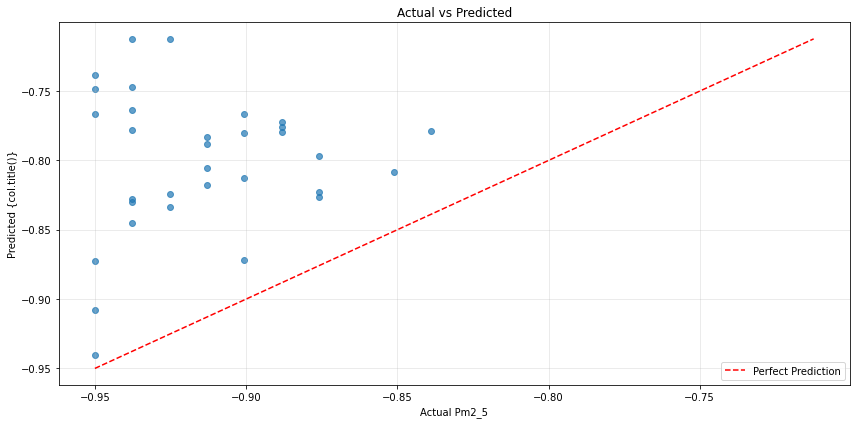

In [ ]:
hp.plot_col_error(df_comp, "pm2_5")

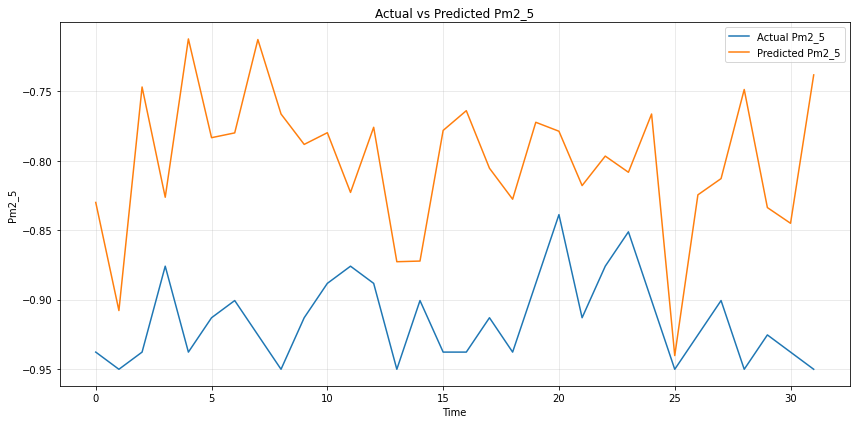

In [ ]:
hp.plot_col_comparison(df_comp, "pm2_5")

Performance is mediocre.
